In [88]:
deps <- c("ISLR", "Metrics", "ggplot2", "tidyr", "dplyr", "patchwork", "gridExtra", "knitr")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}

set.seed(42)
options(scipen=999)

In [137]:
df <- read.csv("./data_v2_edited.csv")

tmp_df <- df[, !(names(df) %in% c("time_elapsed", "cycles"))]
tmp_df <- tmp_df %>%
    group_by(gil, type, command) %>%
    summarise_all(list(median = median)) %>%
    arrange(instructions_median)

kable(tmp_df)



|gil   |type            |command                                | instructions_median| task_clock_median| user_time_median| sys_time_median|
|:-----|:---------------|:--------------------------------------|-------------------:|-----------------:|----------------:|---------------:|
|true  |cpython         |invoke_hashcat.py libhashcat_openmp.so |            44442376|             8.760|        0.0090265|       0.0000000|
|true  |ctypes          |invoke_hashcat.py libhashcat_openmp.so |            80107280|            39.820|        0.0160960|       0.0000000|
|true  |ctypes          |invoke_hashcat.py libhashcat.so        |           118592997|            16.110|        0.0162195|       0.0000000|
|true  |plain           |lib.py                                 |           146146058|            22.285|        0.0222055|       0.0000000|
|false |multithreading  |workers.py                             |           198008716|            39.985|        0.0258195|       0.0113530|
|true  |mul

[1] "Beat standard lib by: 101703681.5"


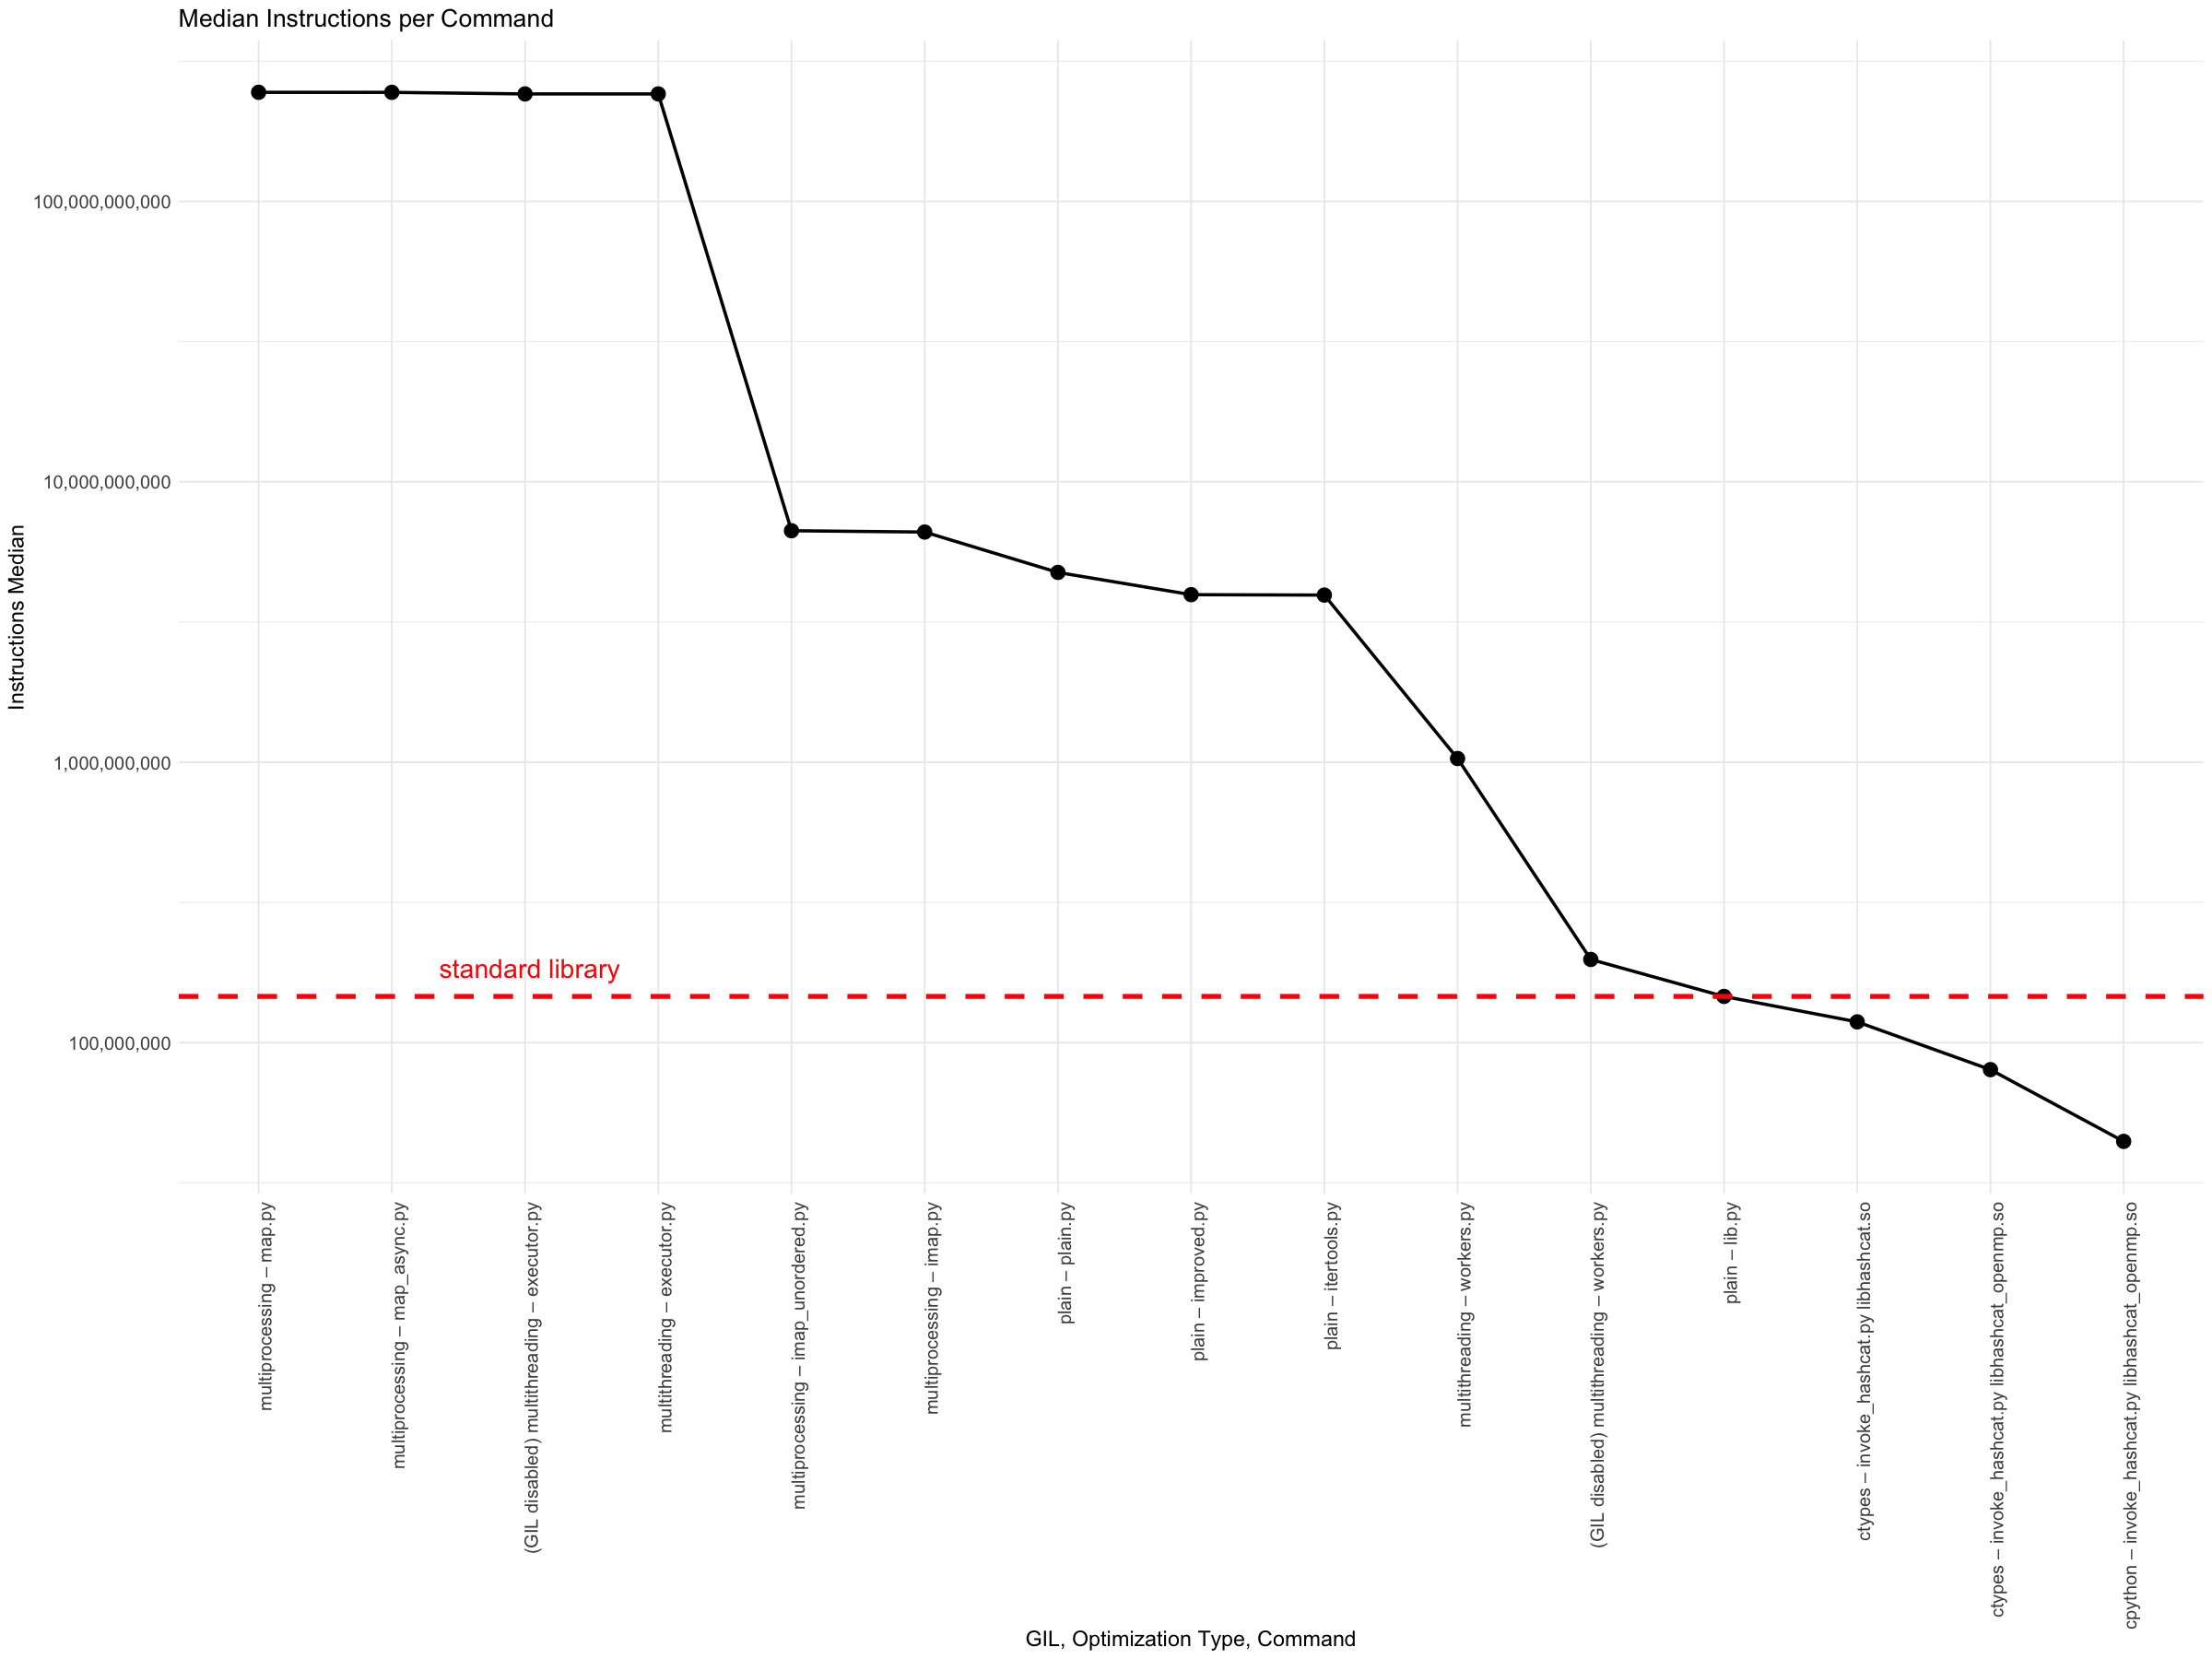

In [136]:
df <- read.csv("./data_v2_edited.csv")

tmp_df <- df[, !(names(df) %in% c("time_elapsed", "cycles"))]
tmp_df <- tmp_df %>%
    group_by(gil, type, command) %>%
    summarise_all(list(median = median)) %>%
    arrange(instructions_median)

tmp_df <- tmp_df[, !(names(tmp_df) %in% c("task_clock_median", "user_time_median", "sys_time_median"))]
tmp_df <- tmp_df[order(-tmp_df$instructions_median),]

options(repr.plot.width = 20, repr.plot.height = 15)
ggplot(tmp_df, aes(x = reorder(ifelse(gil == "false", paste("(GIL disabled)", type, "–", command), paste(type, "–", command)), -instructions_median), y = instructions_median, group = 1)) +
    geom_point(size = 4) +
    geom_line(size = 1) +
    geom_hline(data = tmp_df %>% filter(type == "plain" & command == "lib.py"), aes(yintercept = instructions_median), color = "red", linetype = "dashed", size = 1.5) +
    annotate("text", x = 1, y = tmp_df %>% filter(type == "plain" & command == "lib.py") %>% pull(instructions_median), label = "standard library", color = "red", vjust = -1, hjust = -1, size = 6) +
    scale_y_log10(labels = scales::comma) +
    labs(
        x = "GIL, Optimization Type, Command",
        y = "Instructions Median",
        title = "Median Instructions per Command"
    ) +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 16)
    )

standard_lib_value <- tmp_df %>% filter(type == "plain" & command == "lib.py") %>% pull(instructions_median)
lowest_value <- min(tmp_df$instructions_median)
difference <- lowest_value - standard_lib_value
print(paste("Beat standard lib by:", -difference))

[1] "Beat standard lib by: 13.525"


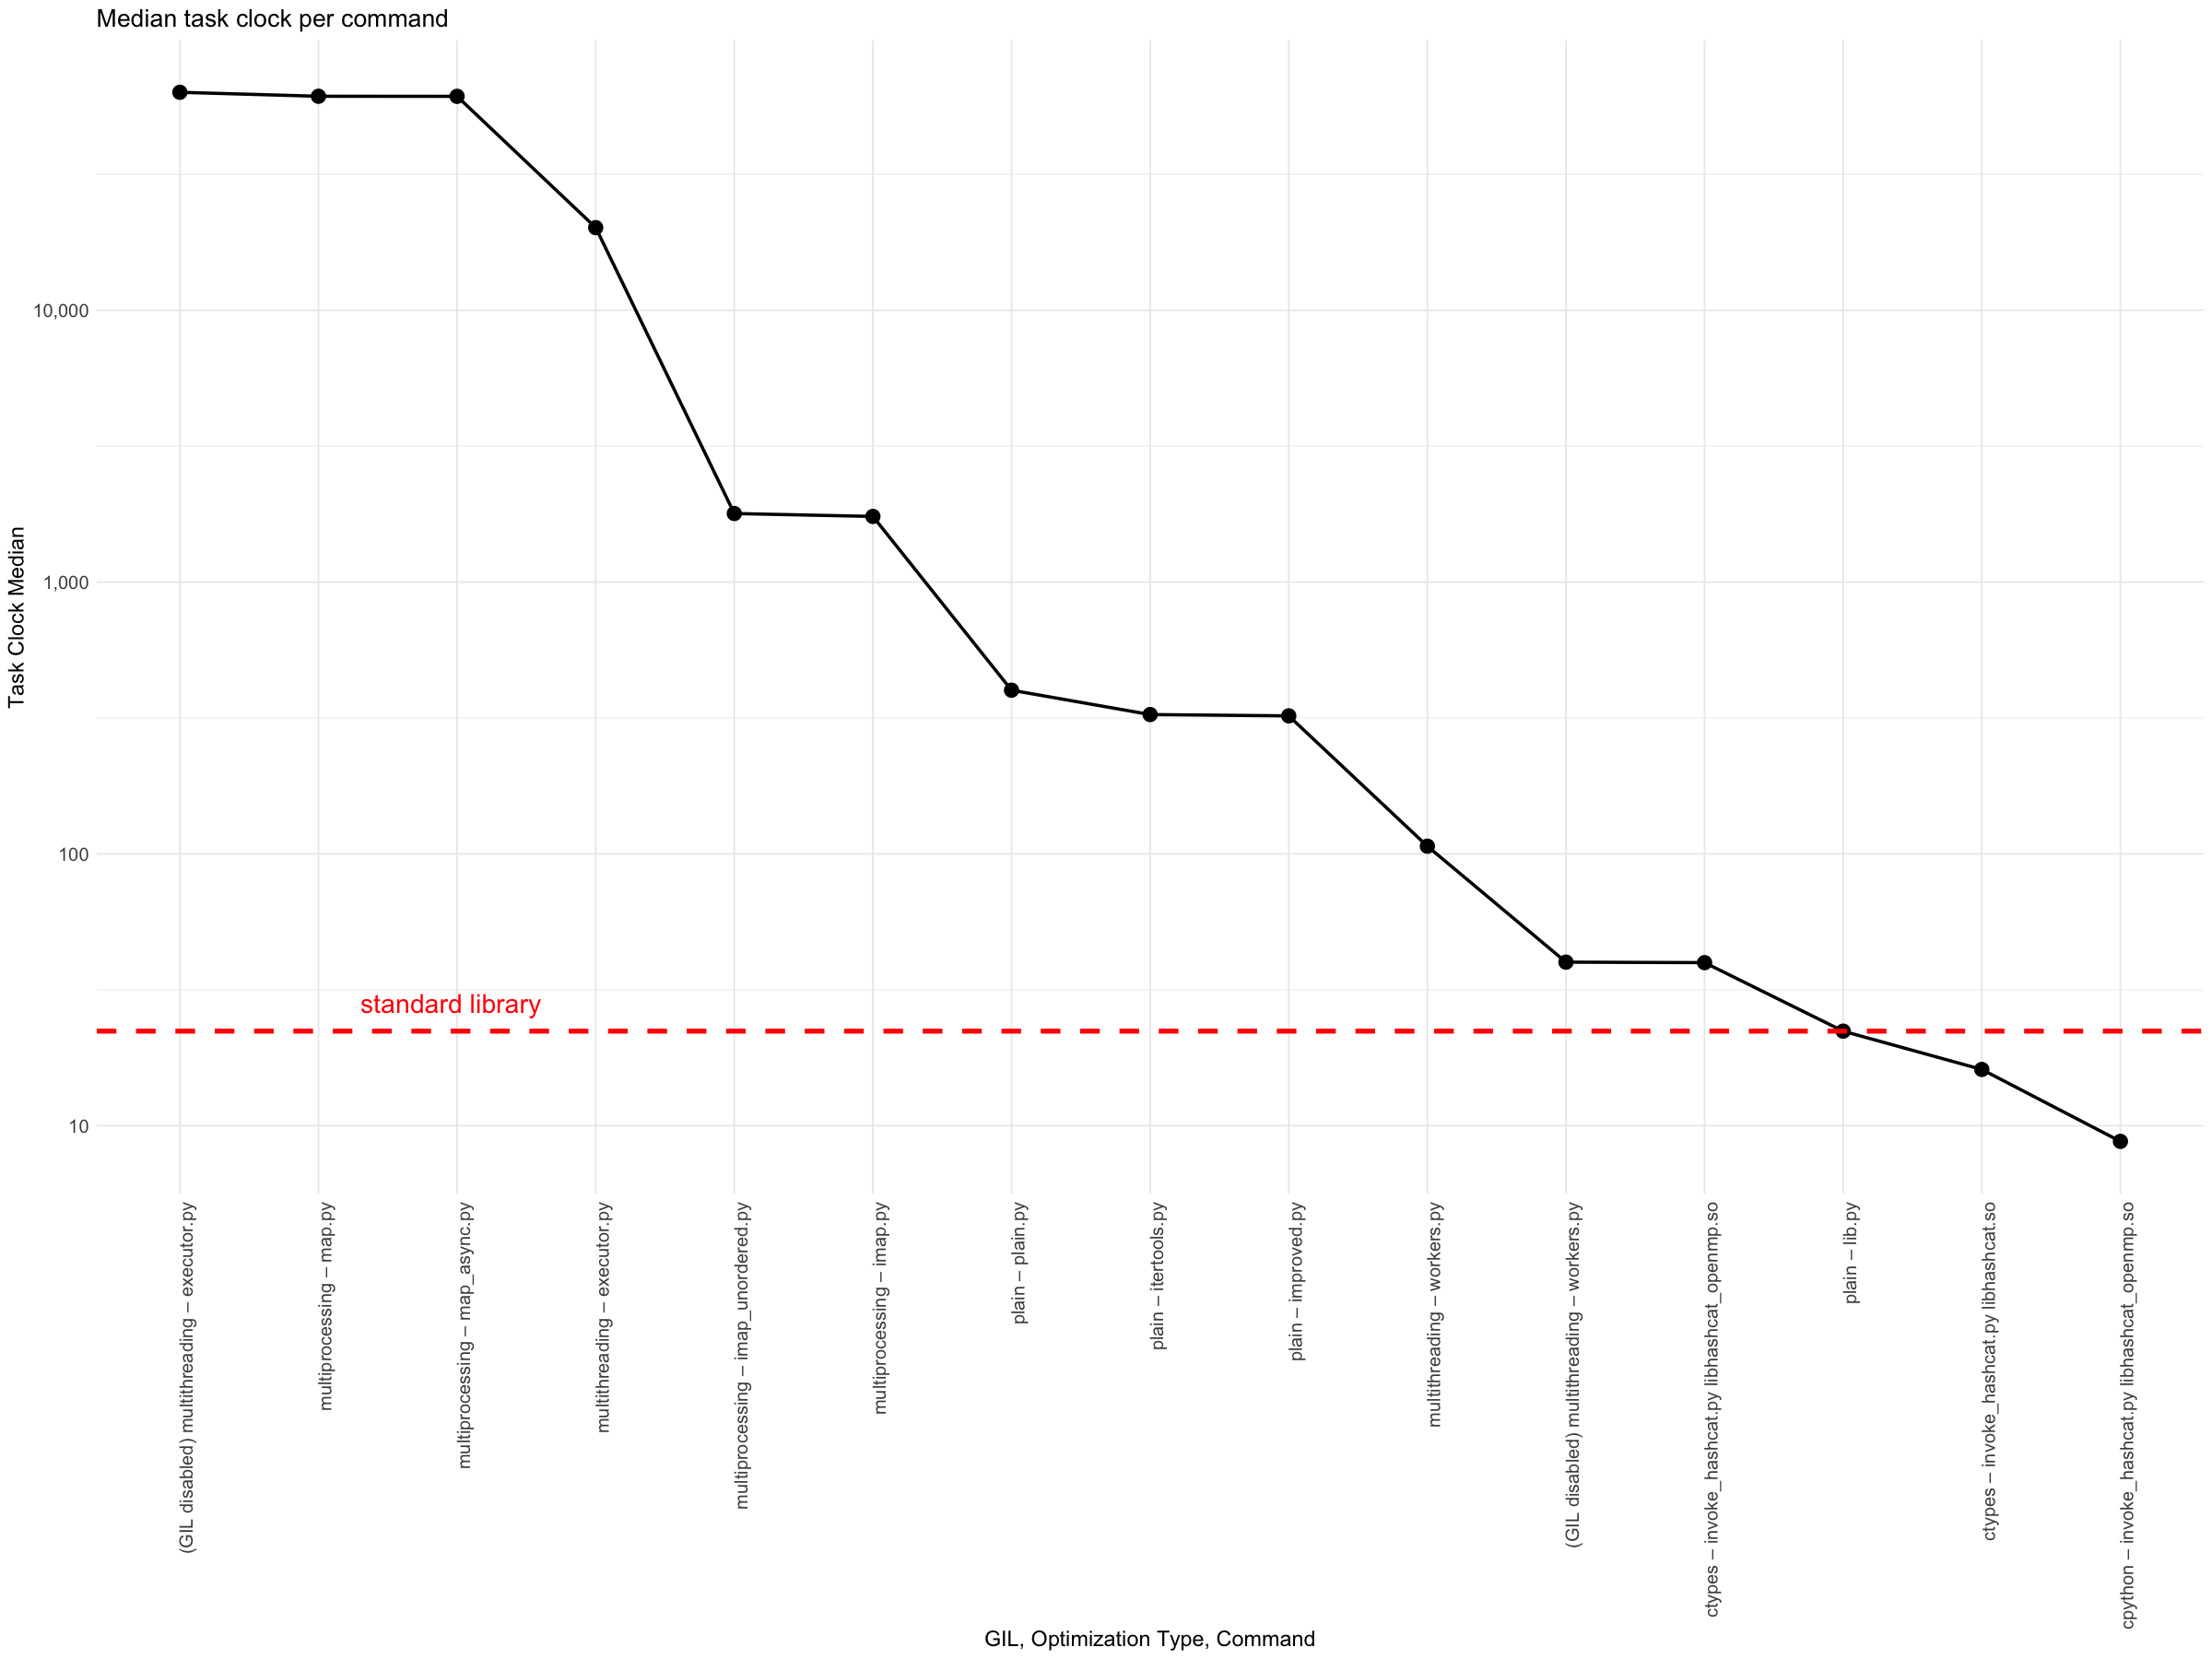

In [135]:
df <- read.csv("./data_v2_edited.csv")

tmp_df <- df[, !(names(df) %in% c("time_elapsed", "cycles"))]
tmp_df <- tmp_df %>%
    group_by(gil, type, command) %>%
    summarise_all(list(median = median)) %>%
    arrange(instructions_median)

tmp_df <- tmp_df[, !(names(tmp_df) %in% c("instructions_median", "user_time_median", "sys_time_median"))]
tmp_df <- tmp_df[order(-tmp_df$task_clock_median),]

options(repr.plot.width = 20, repr.plot.height = 15)
ggplot(tmp_df, aes(x = reorder(ifelse(gil == "false", paste("(GIL disabled)", type, "–", command), paste(type, "–", command)), -task_clock_median), y = task_clock_median, group = 1)) +
    geom_point(size = 4) +
    geom_line(size = 1) +
    geom_hline(data = tmp_df %>% filter(type == "plain" & command == "lib.py"), aes(yintercept = task_clock_median), color = "red", linetype = "dashed", size = 1.5) +
    annotate("text", x = 1, y = tmp_df %>% filter(type == "plain" & command == "lib.py") %>% pull(task_clock_median), label = "standard library", color = "red", vjust = -1, hjust = -1, size = 6) +
    scale_y_log10(labels = scales::comma) +
    labs(
        x = "GIL, Optimization Type, Command",
        y = "Task Clock Median",
        title = "Median task clock per command"
    ) +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 1, size = 12),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.title = element_text(size = 16)
    )

standard_lib_value <- tmp_df %>% filter(type == "plain" & command == "lib.py") %>% pull(task_clock_median)
lowest_value <- min(tmp_df$task_clock_median)
difference <- lowest_value - standard_lib_value
print(paste("Beat standard lib by:", -difference))

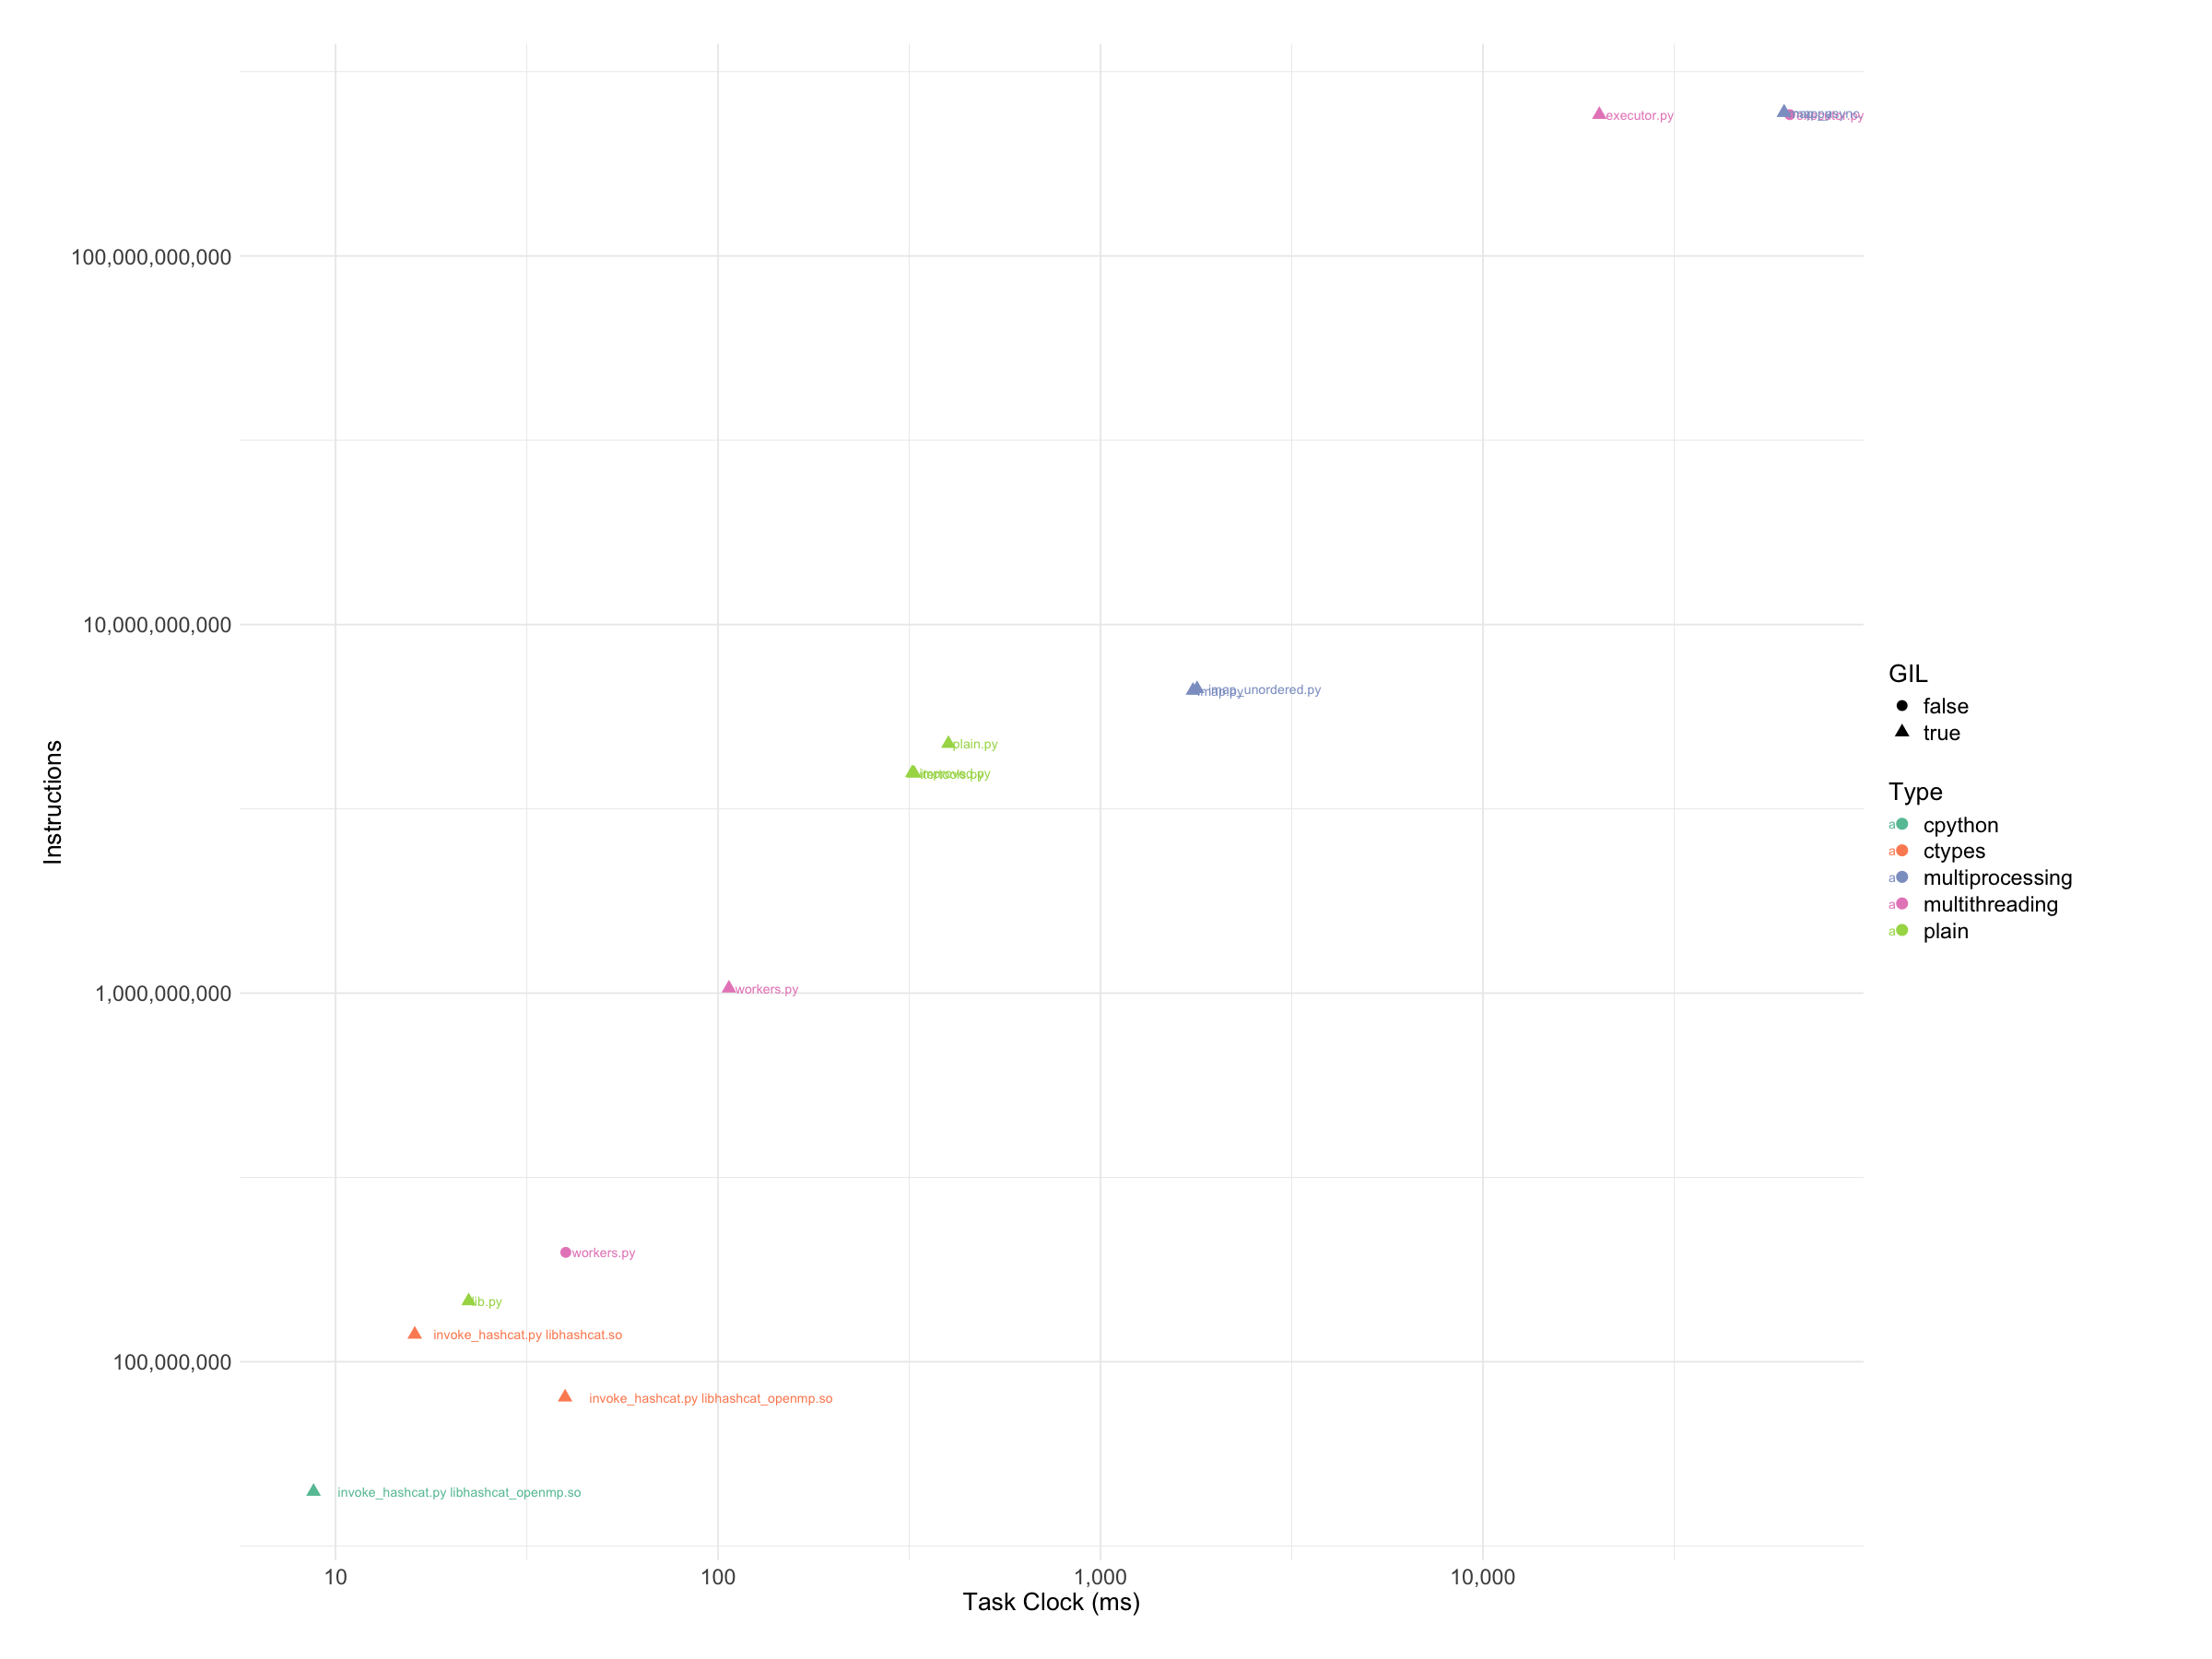

In [139]:
df <- read.csv("./data_v2_edited.csv")

# time_elapsed = also system load, I/O waiting time, context switching, interference by other processes, ... -> only useful for user experience
df <- df[, !(names(df) %in% c("time_elapsed"))]

# task_clock = user_time + system_time
# - user_time = code efficiency -> user space, code efficiency
# - system_time = kernel operation overhead -> kernel space, Process management, Inter-process communication, Context switching, System calls
df <- df[, !(names(df) %in% c("user_time", "sys_time"))]

# cycles also measure NOPs or waiting cores, so it can be misleading
df <- df[, !(names(df) %in% c("cycles"))]

# group by id and get median
df <- df %>%
    group_by(gil, type, command) %>%
    summarise_all(list(median = median)) 

options(repr.plot.width = 20, repr.plot.height = 15)
ggplot(df, aes(x = task_clock_median, y = instructions_median, color = type, shape = gil)) +
    geom_point(size = 3) +
    geom_text(aes(label = command), hjust = -0.1, size = 3) +
    scale_x_log10(labels = scales::comma) +
    scale_y_log10(labels = scales::comma) +
    scale_color_brewer(palette = "Set2") +
    scale_shape_manual(values = c(16, 17)) +
    labs(
        x = "Task Clock (ms)",
        y = "Instructions",
        color = "Type",
        shape = "GIL"
    ) +
    theme_minimal() +
    theme(
        legend.position = "right",
        plot.margin = margin(1, 3, 1, 1, "cm"),
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16),
        plot.title = element_text(size = 18)
    )
